# KERI Core: Multi-Signature Group Identifiers

<div class="alert alert-primary">
<b>🎯 OBJECTIVE</b><hr>
This notebook introduces the concept of multi-signature (multisig) group Autonomic Identifiers (AIDs) in KERI. It will demonstrate how to:
<ul>
<li>Set up individual AIDs that will participate in a multisig group.</li>
<li>Configure and incept a multisig group AID where actions require signatures from multiple participants.</li>
<li>Perform interaction events with the multisig group AID.</li>
<li>Rotate the keys for the multisig group AID.</li>
<li>Understand the structure of inception (<code>icp</code>), interaction (<code>ixn</code>), and rotation (<code>rot</code>) events for multisig group AIDs.</li>
</ul>
</div>

## Introduction to Multi-Signature Identifiers
Multi-signature (multisig) identifier schemes in KERI enhance security and enable collective control over an identifier by requiring signatures from multiple authorized keys to validate an event. This is particularly useful for organizations or groups where shared authority is necessary. A multi-signature identifier is also known as a group identifier, or multi-signature group identifier.

A multi-signature group AID is essentially an identifier whose controlling authority is distributed among a set of participating AIDs. Each key event for this group AID, such as inception, interaction, or rotation, must be authorized by a sufficient number of these participating AIDs according to the defined signing threshold. The signing threshold may be changed with a rotation event and group members may be added or removed as needed.

#### Illustration of end product

The result of this training will be the creation of a multisig group identifier illustrated in the middle of the diagram below.

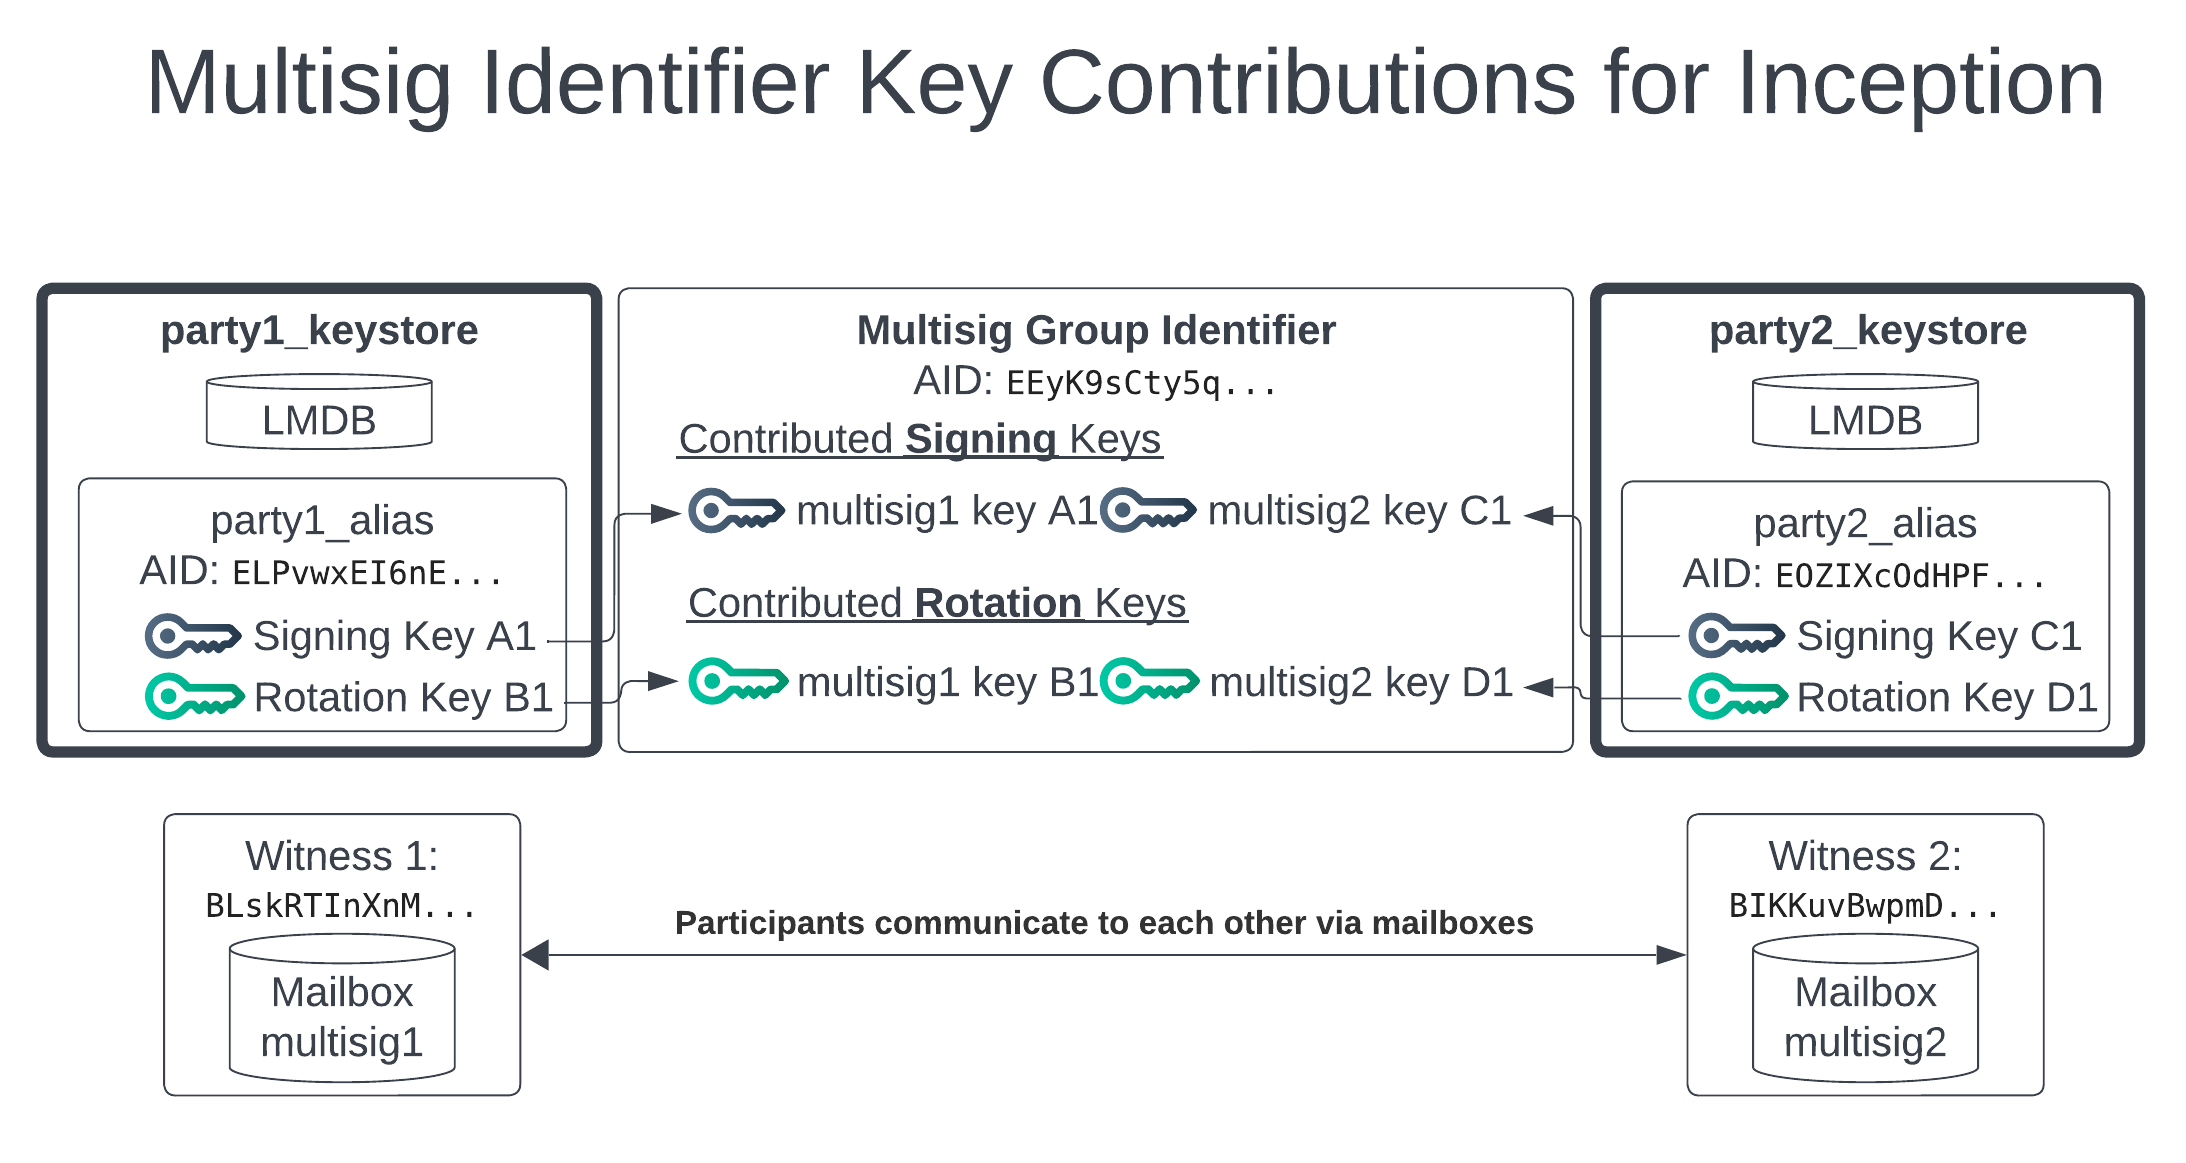

## Initial Setup of Participant AIDs

The setup involves:

- Individual Participant AIDs: Each entity that will be part of the multisig group first has its own individual AID.
- Group Configuration: A configuration is defined specifying which AIDs are members of the group and the signing threshold (e.g., 2 out of 3 participants must sign).
- Group Inception: The multisig group AID is incepted. This is a cooperative process where participating AIDs signal their agreement to form the group. The resulting group AID prefix is self-addressing identifier derived from its inception event data, which includes the participating AIDs and the threshold policies for signing and rotation.
- Group Operations: Subsequent operations like interaction events or key rotations for the group AID also require the specified threshold of signatures from the participating AIDs.

For this notebook, we will create two AIDs, `party1_alias` and `party2_alias`, each in its own keystore. These will act as the initial members of our multisig group.

In [ ]:
# Imports and Utility functions
from scripts.utils import exec, exec_bg, clear_keri
from scripts.utils import pr_continue, pr_title, pr_message
import json
import time

clear_keri()

# Party 1 Keystore
party1_keystore = "party1_keystore"
party1_salt= "0AAW49QDCAuz0I-R1yCY8wa6" # Use hardcoded salt so that the AID stays the same. Swap with `exec("kli salt")` for a dynamic salt.
party1_alias = "party1_alias"

pr_title("Initializing keystores")

# The `keystore_init_config.json` file is used here 
# to pre-configure the keystores with default witness information.
!kli init --name {party1_keystore} \
    --nopasscode \
    --salt {party1_salt} \
    --config-dir ./config \
    --config-file keystore_init_config.json

# multisig2 Keystore
party2_keystore = "party2_keystore"
party2_salt = "0AC_OfvFyZcKRspiawo-Pgwz" # Use hardcoded salt so that the AID stays the same. Swap with `exec("kli salt")` for a dynamic salt.
party2_alias = "party2_alias"

!kli init --name {party2_keystore} \
    --nopasscode \
    --salt {party2_salt} \
    --config-dir ./config \
    --config-file keystore_init_config.json

pr_title("Incepting multisig parts")

# multisig1 AID inception
!kli incept --name {party1_keystore} \
    --alias {party1_alias} \
    --icount 1 \
    --isith 1 \
    --ncount 1 \
    --nsith 1 \
    --wits BBilc4-L3tFUnfM_wJr4S4OJanAv_VmF_dJNN6vkf2Ha \
    --wits BLskRTInXnMxWaGqcpSyMgo0nYbalW99cGZESrz3zapM \
    --wits BIKKuvBwpmDVA4Ds-EpL5bt9OqPzWPja2LigFYZN2YfX \
    --toad 2 \
    --transferable

# multisig2 AID Inception
!kli incept --name {party2_keystore} \
    --alias {party2_alias} \
    --icount 1 \
    --isith 1 \
    --ncount 1 \
    --nsith 1 \
    --wits BBilc4-L3tFUnfM_wJr4S4OJanAv_VmF_dJNN6vkf2Ha \
    --wits BLskRTInXnMxWaGqcpSyMgo0nYbalW99cGZESrz3zapM \
    --wits BIKKuvBwpmDVA4Ds-EpL5bt9OqPzWPja2LigFYZN2YfX \
    --toad 2 \
    --transferable

pr_continue()


##  Creating the Multi-Signature Group AID

With the individual participant AIDs in place, now proceed to create the multisig group AID. This involves several steps: 
- authorizing mailbox roles for discovery
- exchanging OOBIs
- configuring the multisig parameters
- cooperatively incepting the group AID.

### Adding Mailbox Role

To allow the cooperative inception process, each participant AID needs to authorize one of its witnesses to act as a `mailbox`. This allows other participants to send messages (like the group inception proposal) to them indirectly via this witness.

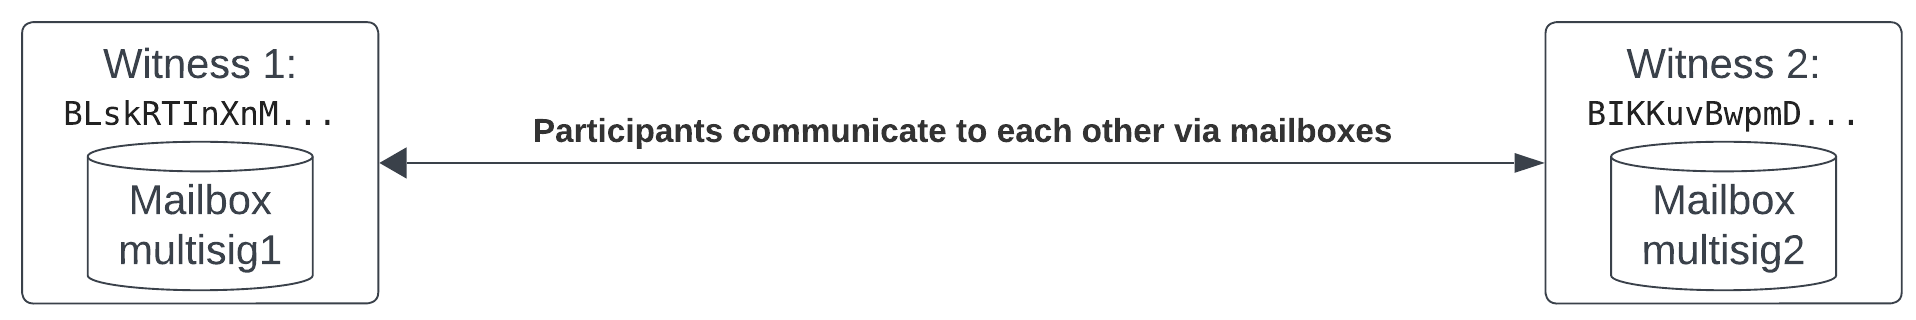

The `kli ends add` command is used to authorize an end role.
`--eid`: Specifies the prefix of the witness AID being authorized for the new role.
`--role`: Defines the role being assigned.

In [ ]:
# Add new endpoint role authorization.
pr_title("Adding mailbox role")

role = "mailbox"

!kli ends add --name {party1_keystore} \
    --alias {party1_alias} \
    --eid BLskRTInXnMxWaGqcpSyMgo0nYbalW99cGZESrz3zapM \
    --role {role}

# Add new endpoint role authorization.
!kli ends add --name {party2_keystore} \
    --alias {party2_alias} \
    --eid BIKKuvBwpmDVA4Ds-EpL5bt9OqPzWPja2LigFYZN2YfX \
    --role {role}

pr_continue()

### Resolving OOBIs

Next, the participants need to discover each other. This is done by generating and resolving Out-of-Band Introductions (OOBIs) that point to their newly authorized mailbox endpoints.

In [ ]:
# OOBI Generation
pr_title("Generating OOBIs")

# party1 generates mailbox OOBI for its AID
party1_oobi = exec(f"kli oobi generate --name {party1_keystore} --alias {party1_alias} --role {role}")

# party2 generates mailbox OOBI for its AID
party2_oobi = exec(f"kli oobi generate --name {party2_keystore} --alias {party2_alias} --role {role}")

pr_message("Party 1 OOBI: " + party1_oobi)
pr_message("Party 2 OOBI: " + party2_oobi)

# OOBI Exchange
pr_title("Resolving OOBIs")
!kli oobi resolve --name {party1_keystore} \
    --oobi-alias {party2_alias} \
    --oobi {party2_oobi}

!kli oobi resolve --name {party2_keystore} \
    --oobi-alias {party1_alias} \
    --oobi {party1_oobi}

pr_continue()

### Configuring the Multi-Signature Group

Setting up the configuration for a multi-signature group identifier is similar to a single-signature identifier with the exception of the "aids" field where the participants are defined as a list of member AID prefixes. All of the other typical configuration including transferability, witnesses, TOAD, and signing and rotation thresholds still apply.

The parameters for the multisig group AID are defined in a JSON configuration file. This file specifies:

- `aids`: A list of the prefixes of the participating AIDs.
- `transferable`: Whether the group AID itself will be transferable (i.e., its keys can be rotated).
- `wits`: A list of witness AIDs for the group AID.
- `toad`: The Threshold of Accountable Duplicity for the group AID's events. This defines how many witness receipts are needed for an event to be considered accountable by the controller group.
- `isith`: The initial signing threshold for the group AID's inception event. This can be an integer (e.g., "2" for 2-of-N) or a list of weights for a weighted threshold scheme. For this example, "2" means both participants must sign.
- `nsith`: The signing threshold for the next key set (for future rotations). Similar to isith.


In [ ]:
# Multisig participants Configuration
pr_title(f"Building multisig config file")

# Multisig participants prefixes
party1_pre = exec(f"kli aid --name {party1_keystore} --alias {party1_alias}")
party2_pre = exec(f"kli aid --name {party2_keystore} --alias {party2_alias}")

pr_message("Party 1 prefix: " + party1_pre)
pr_message("Party 2 prefix: " + party1_pre)

# multisig configuration
multisig_inception_config = {
  "aids": [
    party1_pre,
    party2_pre
  ],
  "transferable": True,
  "wits": [
    "BBilc4-L3tFUnfM_wJr4S4OJanAv_VmF_dJNN6vkf2Ha",
    "BLskRTInXnMxWaGqcpSyMgo0nYbalW99cGZESrz3zapM",
    "BIKKuvBwpmDVA4Ds-EpL5bt9OqPzWPja2LigFYZN2YfX"
  ],
  "toad": 2,
  "isith": "2",
  "nsith": "2"
}

# Specify the filename
file_path = './config/multisig/multisig_inception_config.json'

# Write the configuration data to the JSON file
with open(file_path, 'w') as f:
  json.dump(multisig_inception_config, f, indent=2)

pr_message(f"Multisig config: {file_path}")
!cat {file_path}

pr_continue()

### Incepting the Multi-Signature Group AID

The inception of a multisig group AID is a cooperative process. One participant (here, `party1_alias`) initiates the group inception using `kli multisig incept`.
  - `--group`: Assigns a human-readable alias to the multisig group AID being created.
  - `--file`: Points to the JSON configuration file created in the previous step.  

This command will propose the inception event and wait for other members to join and sign. The other participant(s) (here, `party2_alias`) join the proposed inception using `kli multisig join`.
  - `--group`: Specifies the alias of the group they are joining.
  - `--auto`: Automatically approves the join request **(in a real scenario, this would be an interactive confirmation)**. This command will fetch the proposed event, sign it, and send its signature back.

Once all required signatures are gathered, the inception event is finalized and published to the witnesses.
These commands are run in the background here, as they would normally be interactive, waiting for each other.

In [ ]:
pr_title(f"Incepting multisig AID")

multisig_group = "multisig_group"

command = f"""
kli multisig incept --name {party1_keystore} \
    --alias {party1_alias} \
    --group {multisig_group} \
    --file {file_path} > ./logs/multisig_event.log
"""
incept1_process = exec_bg(command)

command = f"""
kli multisig join --name {party2_keystore} \
    --group {multisig_group} \
    --auto > ./logs/multisig_join.log
"""
join_process = exec_bg(command)

while(incept1_process.poll() is None or join_process.poll() is None): 
    print("Waiting for multisig inception to complete...\n")
    time.sleep(2)

# Show the output of the background processes
pr_message(f"Multisig Event")
!cat ./logs/multisig_event.log

pr_message(f"Multisig Join")
!cat ./logs/multisig_join.log

pr_continue()

### Multi-signature inception result

The diagram below represents the multi-signature identifier created. Each single signature identifier contributed both a signing key and a rotation key, shown with the arrows from the single sig keystores (party1_keystore, party2_keystore) to the virtual multisig group identifier in the middle of the diagram.

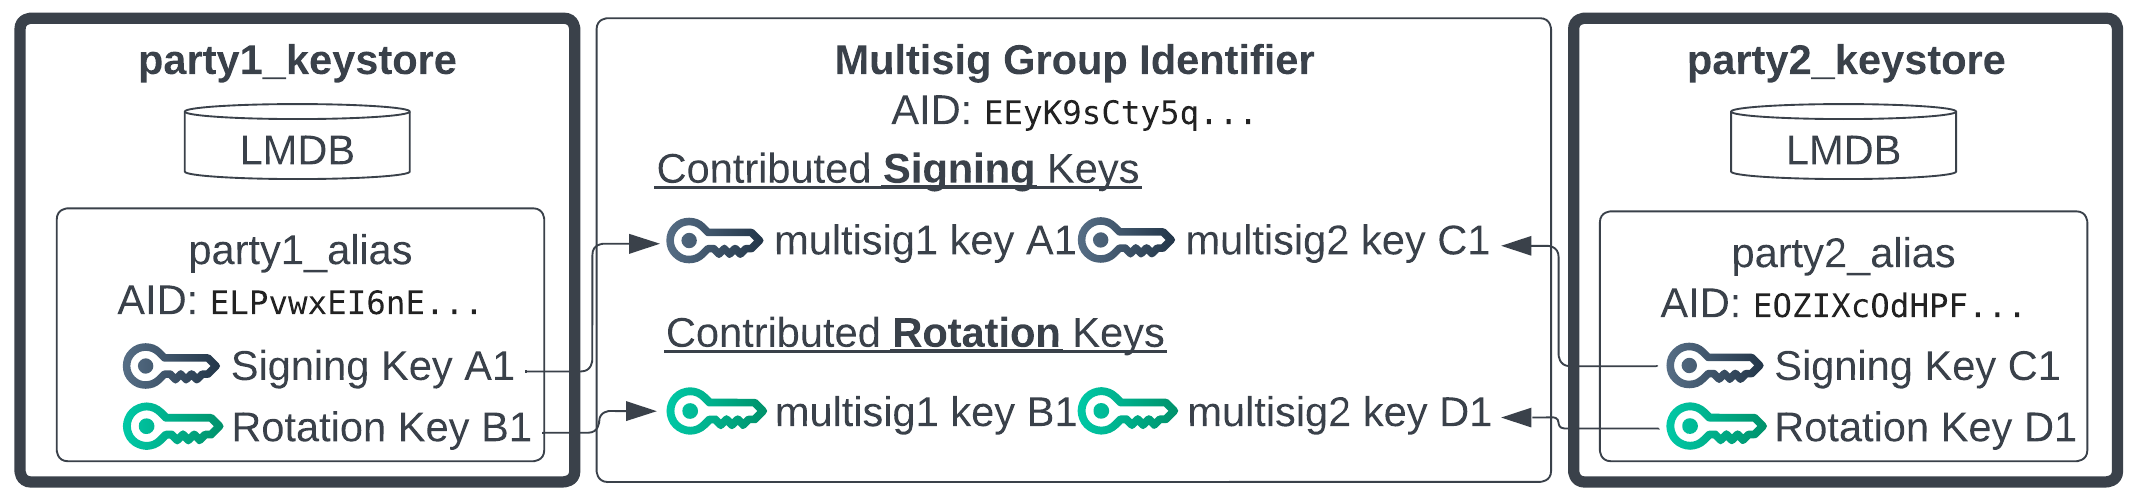

### Verifying Multi-Signature AID Status

After successful inception, you can check the status of the `multisig_group` AID using `kli status --verbose`.
The output shows the inception event (`icp`). Key fields for a multisig AID include:

- `i`: The prefix of the multisig group AID.
- `k`: A list of the public keys of the participating AIDs that form the current signing key set for the group.
- `kt`: The current signing threshold (e.g., "2", meaning 2 signatures are required).
- `n`: A list of digests of the public keys for the next rotation (pre-rotation).
- `nt`: The signing threshold for the next key set.
- `b`: The list of witness AIDs for this group AID.
- `bt`: The Threshold of Accountable Duplicity (TOAD) for this group AID.  

This inception event (`icp`) is an establishment event that cryptographically binds the group AID to its initial set of controlling keys (the participants' keys) and the defined signing policies.

In [ ]:
pr_title(f"Multisig AID status")
!kli status --name party1_keystore --alias multisig_group --verbose

## Signing and Anchoring Arbitrary data in an Interaction Event

When you want to sign and anchor arbitrary data to a key event log for a multisig identifier you use an interaction event. An interaction event (`ixn`) is a non-establishment event used to anchor arbitrary data to the Key Event Log (KEL) of an AID. For a multisig group AID, an interaction event must also be signed by the required threshold of participating AIDs.

The `kli multisig interact` command initiates an interaction event for the group, and `kli multisig join` is used by other participants to add their signatures.

In [ ]:
pr_title(f"Performing interaction event")

# Anchor data for the interaction event (ixn)
data = """'{"d": "arbitrary data"}'""" # Keep string format as is!

command = f"""
kli multisig interact --name {party1_keystore} \
    --alias {multisig_group} \
    --data {data} > ./logs/multisig_event.log
"""

interact1_process = exec_bg(command)

command = f"""
kli multisig join --name {party2_keystore} \
    --group {multisig_group} \
    --auto > ./logs/multisig_join.log
"""
join_process = exec_bg(command)

while(interact1_process.poll() is None or join_process.poll() is None): 
    print("Waiting for multisig interaction to complete...\n")
    time.sleep(2)

# Show the output of the background processes
pr_message(f"Multisig Event")
!cat ./logs/multisig_event.log

pr_message(f"Multisig Join")
!cat ./logs/multisig_join.log

pr_continue()

### Verifying Interaction Event
Let's examine the KEL for `multisig_group` again to see the `ixn` event.  
The interaction event (`ixn`) does not change the establishment keys but anchors data (`a` field) to the KEL. It is signed by the current authoritative keys established by the preceding `icp` event. The `p` field contains the digest of the previous event (`icp` in this case), ensuring the chain's integrity.

In [ ]:
pr_title(f"Multisig AID status")
!kli status --name party1_keystore --alias multisig_group --verbose

## Rotation Event for Multi-Signature Group AID

Rotating the keys for a multisig group AID also requires a cooperative process as each participant must first rotate the keys of its single signature identifier participating as a member of the multi-signature group prior to being able to rotate the group. This is required because each rotation of a multi-signature identifier must use new signing and rotation keys in each rotation event.

### Rotating Individual Participant Keys

First, each individual participant AID must rotate its own keys for the participating single signature identifier. This ensures that when they participate in the group rotation, they are using their new, updated keys. 
- `kli rotate` is used for individual AID key rotation.
- `kli query` is used to ensure other participants are aware of these individual rotations.

Updating each participant on the latest key state via a key state refresh is required in order to create a multi-signature rotation event. This is because the rotation threshold check will fail until there are enough new keys available for a new rotation event to be created for the multi-signature identifier.

In [ ]:
pr_title(f"Rotating multisig participant single signature keys")

!kli rotate --name {party1_keystore} \
    --alias {party1_alias}

!kli query --name {party2_keystore} \
    --alias {party2_alias} \
    --prefix {party1_pre}

!kli rotate --name {party2_keystore} \
    --alias {party2_alias}

!kli query --name {party1_keystore} \
    --alias {party1_alias} \
    --prefix {party2_pre}

pr_continue()

You want to make sure that the latest sequence number, which will be sequence number one, shows in the status for each key state query. This is required so that each participant in the multisig has a new key to contribute to the multisig rotation.

### Rotating the Multi-Signature Group Keys
Once the participants have rotated their individual keys, the group rotation can proceed.
The `kli multisig rotate` command initiates the rotation for the group.

- `--smids`: **Signing member identifiers**; specifies the list of participant AIDs that will contribute signing keys for the current rotation event. The contributed keys will be aauthorized to sign events after this rotation completes.
- `--rmids`: **Rotation member identifiers**; specifies the list of participant AIDs that will contribute rotation keys, as digests, to form the set of cryptographic pre-comittments of keys (pre-rotation) that will become the next set of signing keys after the next rotation.
- `--isith`: **Signing (current) threshold**; The signing threshold for the current rotation event. Here, `["1/2", "1/2"]` represents a weighted threshold where each of the two participants has a weight of 1/2, and a sum of 1 (i.e., both signatures) is required.
- `--nsith`: **Next (rotation) threshold**; The signing threshold for the next set of keys (pre-rotation).  

Again, `kli multisig join` is used by the other participant to co-sign the group rotation event.

In [ ]:
pr_title(f"Rotating multisig group")

command = f"""
kli multisig rotate --name {party1_keystore} \
    --alias {multisig_group} \
    --smids {party1_pre} \
    --smids {party2_pre} \
    --rmids {party1_pre} \
    --rmids {party2_pre} \
    --isith '["1/2", "1/2"]' \
    --nsith '["1/2", "1/2"]' > ./logs/multisig_event.log
"""
incept_process = exec_bg(command)

command = f"""
kli multisig join --name {party2_keystore} \
    --group {multisig_group} \
    --auto > ./logs/multisig_join.log
"""
join_process = exec_bg(command)

while(incept_process.poll() is None or join_process.poll() is None): 
    print("Waiting for multisig rotation to complete...\n")
    time.sleep(2)

# Show the output of the background processes
pr_message(f"Multisig Event")
!cat ./logs/multisig_event.log

pr_message(f"Multisig Join")
!cat ./logs/multisig_join.log

pr_continue()

### Verifiying rotation event

Let's inspect the KEL of `multisig_group` one last time.
The `rot` event (type `rot`) is an establishment event that signifies a change in the controlling keys.

- `s`: The sequence number is incremented.
- `p`: Contains the digest of the previous event (the ixn event in this case).
- `kt`: The signing threshold for this rotation. It's now a list `["1/2", "1/2"]`, reflecting the weighted threshold specified.
- `k`: The list of public keys of the participants that are now the current authoritative signers for the group. These are the new keys from the individual participant rotations.
- `nt`: The signing threshold for the next rotation (pre-rotation).
- `n`: A list of digests of the public keys for the next rotation.
- `br`: List of witnesses to remove (empty in this case).
- `ba`: List of witnesses to add (empty in this case).

This `rot` event demonstrates how the control of the multisig group AID has been transferred to a new set of keys (derived from the participants' new keys) and how a new pre-rotation commitment has been made for the next cycle, all while maintaining the integrity of the KEL through cryptographic chaining and multi-signature authorization.

In [ ]:
pr_title(f"Multisig AID status")
!kli status --name party1_keystore --alias multisig_group --verbose

<div class="alert alert-prymary">
<b>📝 SUMMARY</b><hr>
This notebook demonstrated the creation and management of a multi-signature (multisig) group AID in KERI.
<ul>
<li><b>Participant Setup:</b> Individual AIDs for each participant were created and their mailboxes configured for discovery via OOBIs.</li>
<li><b>Group Configuration:</b> A JSON file defined the participating AIDs, witness set, TOAD, and signing thresholds (<code>isith</code>, <code>nsith</code>) for the group.</li>
<li><b>Group Inception (<code>icp</code>):</b> The multisig group AID was incepted cooperatively using <code>kli multisig incept</code> by one participant and <code>kli multisig join</code> by the other(s). The resulting <code>icp</code> event in the group's KEL lists the participants' public keys (<code>k</code>) and the signing threshold (<code>kt</code>).</li>
<li><b>Group Interaction (<code>ixn</code>):</b> An interaction event was performed by the group, requiring signatures from the participants according to the current threshold. The <code>ixn</code> event anchored data to the group's KEL.</li>
<li><b>Group Rotation (<code>rot</code>):</b>
<ul>
<li>Individual participant AIDs first rotated their own keys.</li>
<li>The multisig group AID then performed a rotation using <code>kli multisig rotate</code> and <code>kli multisig join</code>. This involved specifying the new set of signing members (<code>--smids</code>), the pre-rotated members for the next rotation (<code>--rmids</code>), and potentially new signing thresholds (<code>--isith</code>, <code>--nsith</code>), which can include weighted schemes.</li>
<li>The <code>rot</code> event in the group's KEL updated the list of authoritative keys (<code>k</code>), the signing threshold (<code>kt</code>), and the pre-rotation commitment (<code>n</code>, <code>nt</code>).</li>
</ul>
</li>
</ul>
Throughout this process, KERI's cryptographic chaining and signature verification ensure the integrity and authenticity of the multisig group's key events.
</div>